# Pneumonia X-ray Image Classifier (PyTorch & ResNet18)

In [1]:
import torch
from IPython.core.pylabtools import figsize
from numpy.random import shuffle
from torch import nn


In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [3]:
from pathlib import Path

data_path = Path("balance_data_chest_xray") #use the balanced dataset created in x_ray_model_2

train_dir = data_path / "train"
val_dir = data_path / "val"
test_dir = data_path / "test"


if data_path.is_dir():
    print(f"Found data in directory at {data_path.resolve()}")
else:
    print(f"Data not found at {data_path.resolve()}, please enter data folder here")

Found data in directory at /Users/jacobzeman/Desktop/xray_pneumonia_project/balance_data_chest_xray


## Lets inspect whats in "balance_data_chest_xray"

In [4]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

walk_through_dir(data_path)

There are 3 directories and 1 images in 'balance_data_chest_xray
There are 2 directories and 0 images in 'balance_data_chest_xray/test
There are 0 directories and 977 images in 'balance_data_chest_xray/test/PNEUMONIA
There are 0 directories and 835 images in 'balance_data_chest_xray/test/NORMAL
There are 2 directories and 0 images in 'balance_data_chest_xray/train
There are 0 directories and 1574 images in 'balance_data_chest_xray/train/PNEUMONIA
There are 0 directories and 1583 images in 'balance_data_chest_xray/train/NORMAL
There are 2 directories and 0 images in 'balance_data_chest_xray/val
There are 0 directories and 1005 images in 'balance_data_chest_xray/val/PNEUMONIA
There are 0 directories and 827 images in 'balance_data_chest_xray/val/NORMAL


## Visualizing original images using matplotlib

Random image path: balance_data_chest_xray/train/NORMAL/IM-0650-0001-0001.jpeg
Image class: NORMAL
Image height: 1341
Image widthL 1682


(np.float64(-0.5), np.float64(1681.5), np.float64(1340.5), np.float64(-0.5))

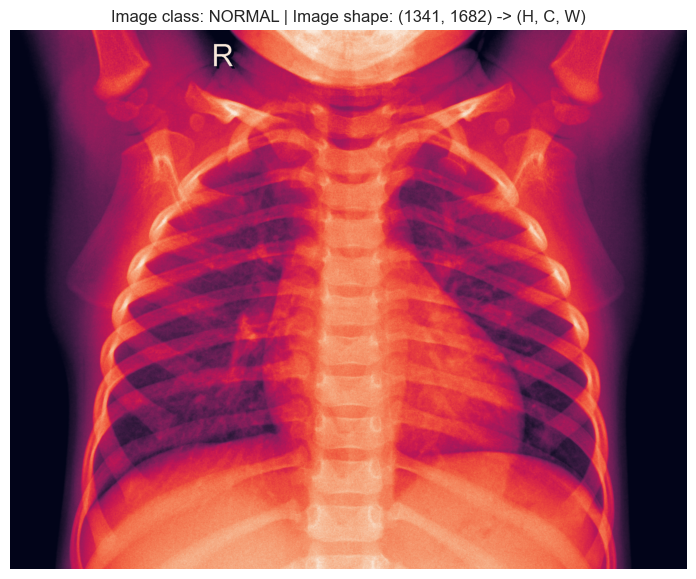

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#get all image paths
image_path_list = list(data_path.glob("*/*/*.jpeg"))

#get random image path
random_image_path = random.choice(image_path_list)

#get image class from path name
image_class = random_image_path.parent.stem

#open image
img = Image.open(random_image_path)

#print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image widthL {img.width}")

#turn image into numpy array (for matplotlib)
img_as_array = np.asarray(img)

#plot image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> (H, C, W)")
plt.axis(False)

## Let's create our datasets and dataloaders

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 32

#Transforms (grayscale, resize, tensor, normalize)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

#Creating datasets with ImageFolder, and transforms
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

#creating DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Lets Visualize the Class distribution

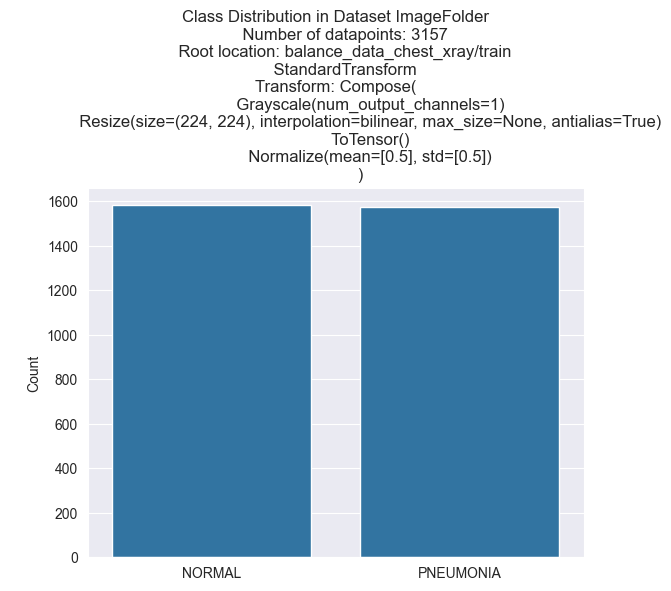

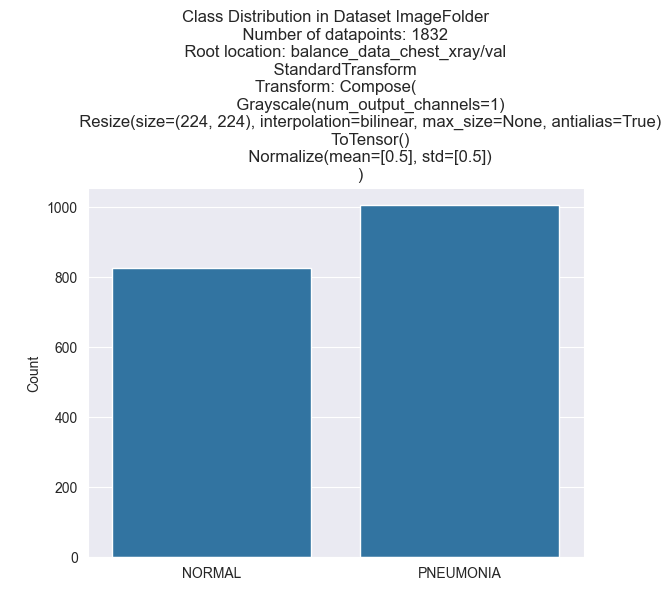

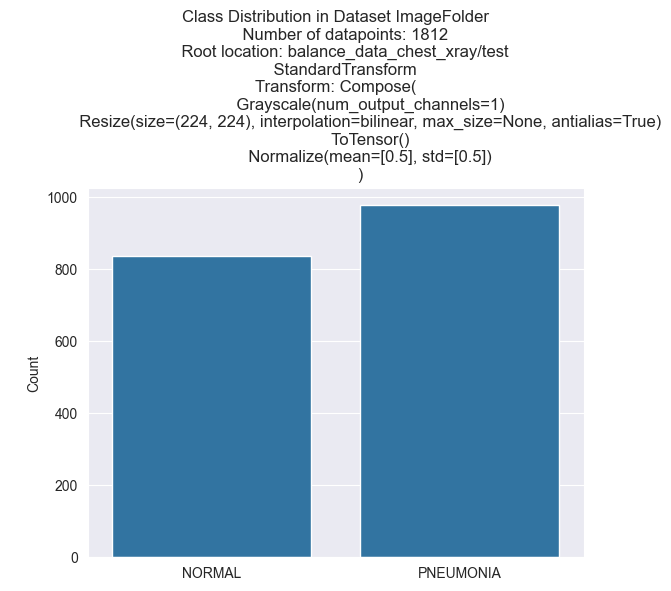

In [7]:
import seaborn as sns
from collections import Counter

def distribution_graph(dataset):
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)
    sns.barplot(x=[dataset.classes[i] for i in label_counts.keys()],
                y=list(label_counts.values()))
    plt.title(f"Class Distribution in {dataset}")
    plt.ylabel("Count")
    plt.show()

distribution_graph(train_dataset)
distribution_graph(val_dataset)
distribution_graph(test_dataset)

## Let's visualize transformed images

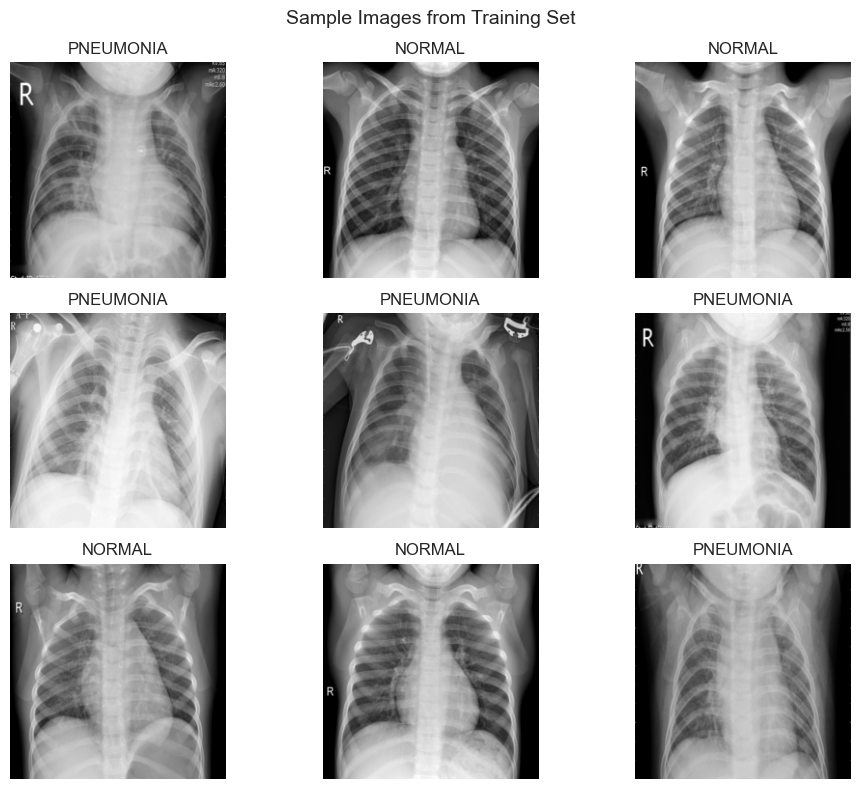

In [8]:
def show_images(dataloader, class_names):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].squeeze(0) # (1, H, W) -> (H, W)
        ax.imshow(img, cmap='gray')
        ax.set_title(class_names[labels[i].item()])
        ax.axis('off')
    plt.suptitle("Sample Images from Training Set", fontsize=14)
    plt.tight_layout(),
    plt.show()

show_images(train_dataloader, train_dataset.classes)

## Now lets write the real transforms for proper Data Augmentation of the images

In [9]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=3),
    transforms.RandomAffine(degrees=0, translate=(0.03, 0.03)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


## Load & Prepare DataLoaders

In [10]:
train_dir, test_dir, val_dir

(PosixPath('balance_data_chest_xray/train'),
 PosixPath('balance_data_chest_xray/test'),
 PosixPath('balance_data_chest_xray/val'))

In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(train_dir, train_transform)
val_dataset = ImageFolder(val_dir, test_val_transform)
test_dataset = ImageFolder(test_dir, test_val_transform)

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
class_names

['NORMAL', 'PNEUMONIA']

## Visualize transformed images

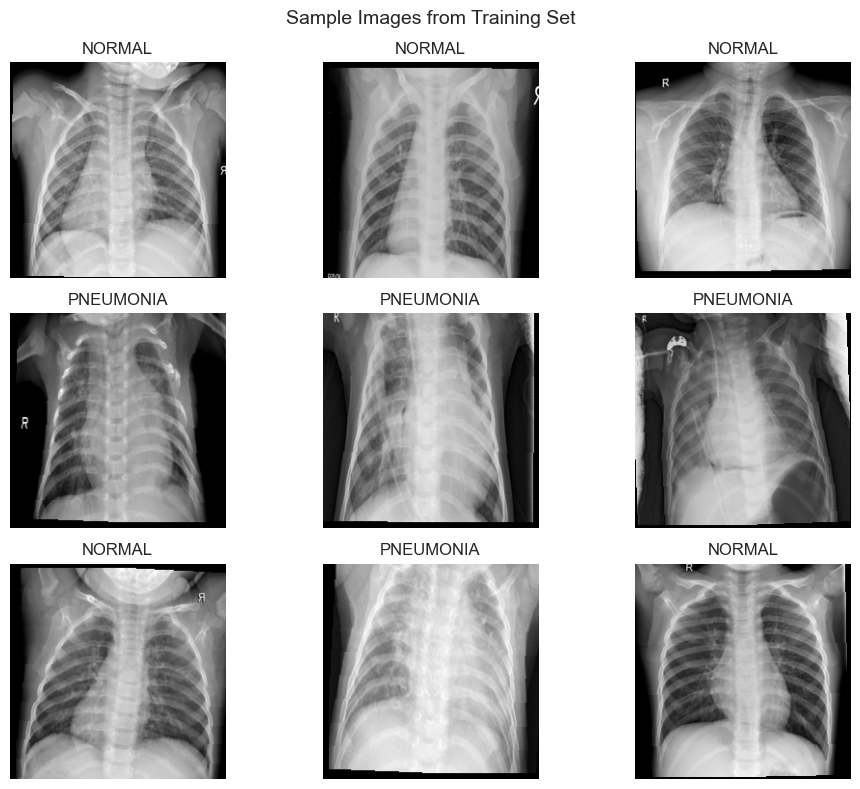

In [12]:
show_images(train_dataloader, class_names)

## We are using pretrained model ResNet18. We have to modify it for Grayscale X-ray input

In [13]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights

#load ResNet18
#we needed to download the pretrained weights from "https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html"

weights_path = "resnet18-f37072fd.pth"
weights = torch.load(weights_path)
model = models.resnet18()
model.load_state_dict(weights)

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) #adjust for 1 channel

#replace classifier head
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)
print(f"Device: {device}")

Device: mps


## Now let's build our training loop

In [14]:
from tqdm.auto import tqdm
from torch import nn

def train_model(model,
                train_dataloader,
                val_dataloader,
                loss_fn,
                optimizer,
                device,
                epochs,
                scheduler=None):

    results = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": []}

    epoch_loop = tqdm(range(epochs), desc="Training Progress")

    for epoch in epoch_loop:

        ###Training
        model.train()
        train_loss, train_acc = 0, 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device).long() ##nn.CrossEntropyLoss() requires taget labels to be of int(long) type

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred_class = torch.argmax(y_pred, dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y)

        ###Evaluation
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.inference_mode():
            for X, y in val_dataloader:
                X, y = X.to(device), y.to(device).long()
                val_logits = model(X)
                loss = loss_fn(val_logits, y)
                val_loss += loss.item()

                val_pred_class = torch.argmax(val_logits, dim=1)
                val_acc += (val_pred_class == y).sum().item() / len(y)

        #Averages
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        #scheduler step
        if scheduler is not None:
            scheduler.step(val_loss)

        #Get current learning rate (for printing)
        curr_lr = optimizer.param_groups[0]['lr']

        #print after each epoch
        print(f"Epoch: {epoch+1}/{epochs} | Learning Rate: {curr_lr:.6f}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Evaluation Loss: {val_loss:.4f} | Evaluation Acc: {val_acc:.4f}")

    return results


## Lets now pick loss function, optimizer and scheduler and finally do our loop!

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

#loss function/criterion
loss_fn = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
#scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=1, min_lr=1e-6)

EPOCHS = 15

model_results = train_model(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=val_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device,
                            epochs=EPOCHS,
                            scheduler=scheduler)


Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15 | Learning Rate: 0.000500
Train Loss: 0.1430 | Train Acc: 0.9402
Evaluation Loss: 0.2967 | Evaluation Acc: 0.9143
Epoch: 2/15 | Learning Rate: 0.000500
Train Loss: 0.1170 | Train Acc: 0.9534
Evaluation Loss: 0.1873 | Evaluation Acc: 0.9343
Epoch: 3/15 | Learning Rate: 0.000150
Train Loss: 0.1045 | Train Acc: 0.9620
Evaluation Loss: 0.0871 | Evaluation Acc: 0.9661
Epoch: 4/15 | Learning Rate: 0.000150
Train Loss: 0.0793 | Train Acc: 0.9711
Evaluation Loss: 0.0537 | Evaluation Acc: 0.9822
Epoch: 5/15 | Learning Rate: 0.000045
Train Loss: 0.0559 | Train Acc: 0.9798
Evaluation Loss: 0.0771 | Evaluation Acc: 0.9747
Epoch: 6/15 | Learning Rate: 0.000045
Train Loss: 0.0441 | Train Acc: 0.9826
Evaluation Loss: 0.0435 | Evaluation Acc: 0.9865
Epoch: 7/15 | Learning Rate: 0.000013
Train Loss: 0.0359 | Train Acc: 0.9863
Evaluation Loss: 0.0485 | Evaluation Acc: 0.9828
Epoch: 8/15 | Learning Rate: 0.000013
Train Loss: 0.0300 | Train Acc: 0.9886
Evaluation Loss: 0.0453 | Evaluation Acc:

{'train_loss': [0.14301068142921936,
  0.11700890407041468,
  0.10448585094112639,
  0.0792557786058898,
  0.05586100872041601,
  0.04405690510898377,
  0.03590500081014453,
  0.02995137718031089,
  0.03207310320188602,
  0.02324555282048279,
  0.02865996484461269,
  0.02761933890305403,
  0.026164066563877795,
  0.026041093835080364,
  0.025467658144976906],
 'train_acc': [0.9401755651755651,
  0.9534331409331409,
  0.9619558682058682,
  0.9711099086099085,
  0.9797979797979798,
  0.9826388888888888,
  0.9862614237614237,
  0.9886363636363636,
  0.9894179894179894,
  0.9933712121212122,
  0.9913119288119288,
  0.9914772727272727,
  0.9917929292929293,
  0.992739898989899,
  0.9921085858585859],
 'val_loss': [0.29667178382862464,
  0.18726602469955808,
  0.08711591483382829,
  0.053695956546138845,
  0.07709178705634509,
  0.04349118669653825,
  0.048517356293500756,
  0.045254009917824016,
  0.04823793722055692,
  0.04401580607799556,
  0.04176650352220067,
  0.051339949585059816,
  0

## BEAUTIFUL WE HAVE AN EVALUATION ACCURACY OF 98%
## Now lets visualize loss curves

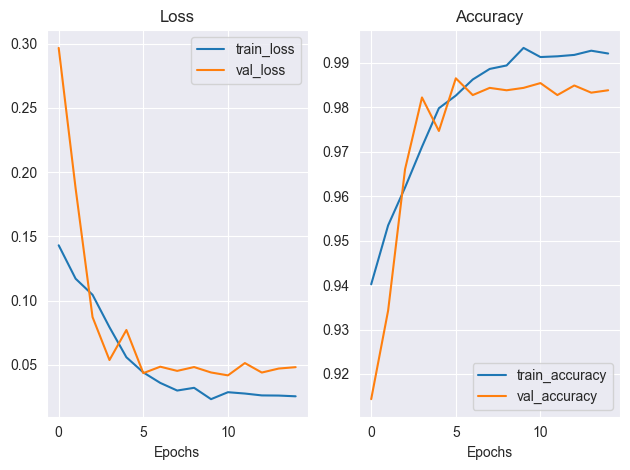

In [17]:
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """plots training curves of a results dictionary"""

    #get loss values of the results dictionary (train and evaluation)
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    #get accuracy values of the results dictionary (training and evaluation)
    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    #how many epoch?
    epochs = range(len(results["val_loss"]))

    #setup a plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.grid(True)
    plt.legend()

    #plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

plot_loss_curves(model_results)


## Let's now evaluate on the test set & plot Confusion Matrix

              precision    recall  f1-score   support

      NORMAL       0.97      1.00      0.98       835
   PNEUMONIA       1.00      0.97      0.98       977

    accuracy                           0.98      1812
   macro avg       0.98      0.98      0.98      1812
weighted avg       0.98      0.98      0.98      1812



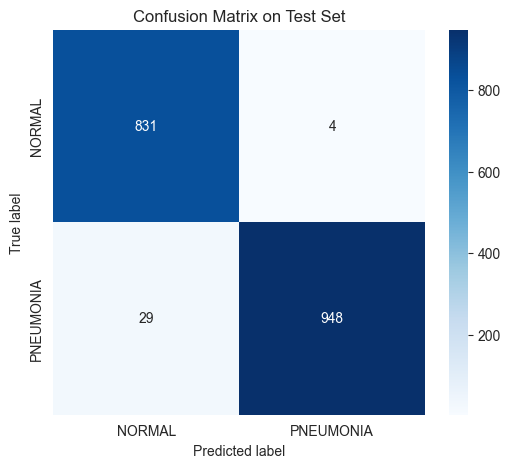

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#evaluation
model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device).long()
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

#print classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

#plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Conclusion. A very strong model with great metrics! 98% overall is fantastic.
## Let's save the model!

In [19]:
torch.save(model.state_dict(), "xray_model_weights.pth")